<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction


**What?** Quantile regression, from linear models to trees to deep learning

**Reference:** https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3 <br>
**Reference:** https://colab.research.google.com/drive/1nXOlrmVHqCHiixqiMF6H8LSciz583_W2 <br>



# Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from sklearn import ensemble
import tensorflow as tf
from tensorflow import keras
import tensorflow.compat.v1 as tf

# Keras and TensorFlow options

In [2]:
EPOCHS = 200
BATCH_SIZE = 32
UNITS = 512

# Graph options

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 1.8  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Dataset


- Boston housing dataset
- ~ 500 pts so not very big.



In [4]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

In [5]:
train_data.shape

(404, 13)

In [6]:
test_data.shape

(102, 13)

In [7]:
# Make dataframe
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

train_df = pd.DataFrame(train_data, columns=column_names)
test_df = pd.DataFrame(test_data, columns=column_names)

In [8]:
# Normalise
train_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


In [9]:
mean = train_df.mean(axis=0)
std = train_df.std(axis=0)
train_df = (train_df - mean) / std
test_df = (test_df - mean) / std

In [10]:
x_train = train_df.AGE
x_test = test_df.AGE

In [11]:
# Denormalise
def denorm_AGE(x):
    return x * std.AGE + mean.AGE

x_train_denorm = denorm_AGE(x_train)
x_test_denorm = denorm_AGE(x_test)

In [12]:
# Reformat data for statsmodels.
X_train = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)

In [13]:
# Reformat data for tensorflow.
x_train_expanded = np.expand_dims(x_train, 1)
x_test_expanded = np.expand_dims(x_test, 1)
train_labels_expanded = np.expand_dims(train_labels, 1)

# Initialize result

In [14]:
# Dataset per method, quantile, and x value.
METHODS = ['OLS', 'QuantReg', 'Random forests', 'Gradient boosting', 'Keras',
           'TensorFlow']

QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]
# QUANTILES.reverse()  # Test out to see if we're getting different results.

quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

In [15]:
# sns.set_palette(sns.color_palette('Blues', len(QUANTILES)))
sns.set_palette(sns.color_palette('Blues'))
# Set dots to a light gray
dot_color = sns.color_palette('coolwarm', 3)[1]

In [16]:
preds = np.array([(method, q, x) 
                  for method in METHODS 
                  for q in QUANTILES
                  for x in x_test])
preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'x']
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))

In [17]:
preds['label'] = np.resize(test_labels, preds.shape[0])

# Quantile loss example


- Just as regressions minimize the squared-error loss function to predict a single point estimate, quantile regressions minimize the quantile loss in predicting a certain quantile. 
- The most popular quantile is the median, or the 50th percentile, and in this case the quantile loss is simply the sum of absolute errors.



In [18]:
def quantile_loss(q, y, f):
    """
    q: Quantile to be evaluated, e.g., 0.5 for median.
    y: True value.
    f: Fitted or predicted value.
    """
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

In [19]:
quantile_loss_example_e = np.linspace(-1, 1, 1000)
quantile_loss_example_loss_10 = quantile_loss(0.1, 0, quantile_loss_example_e)
quantile_loss_example_loss_50 = quantile_loss(0.5, 0, quantile_loss_example_e)
quantile_loss_example_loss_90 = quantile_loss(0.9, 0, quantile_loss_example_e)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


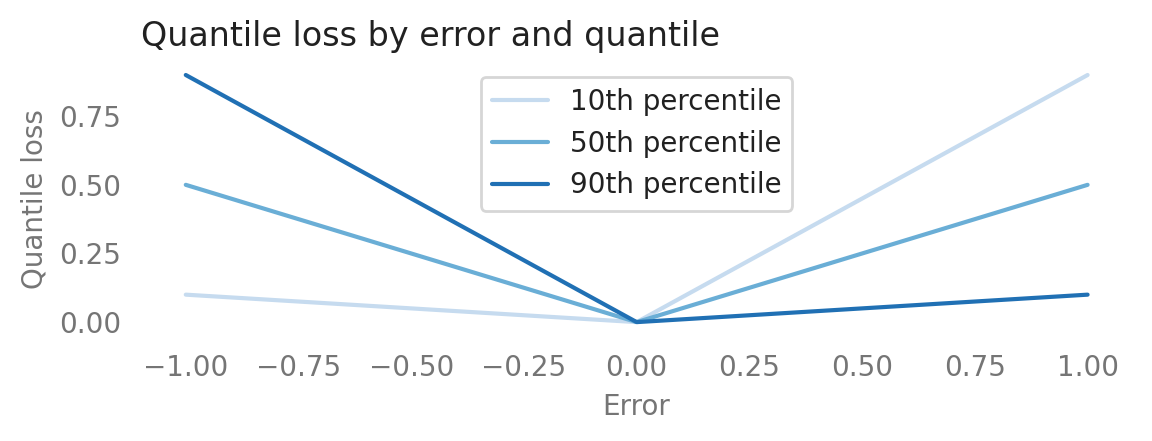

In [20]:
with sns.color_palette('Blues', 3):
    plt.plot(quantile_loss_example_e, quantile_loss_example_loss_10)
    plt.plot(quantile_loss_example_e, quantile_loss_example_loss_50)
    plt.plot(quantile_loss_example_e, quantile_loss_example_loss_90)
    plt.legend([str(int(q * 100)) + 'th percentile' for q in [0.1, 0.5, 0.9]])
    sns.despine(left=True, bottom=True)
    plt.xlabel('Error')
    plt.ylabel('Quantile loss')
    plt.title('Quantile loss by error and quantile', loc='left');

In [21]:
quantile_loss_example_q = np.linspace(0.01, 0.99, 99)
quantile_loss_example_loss_neg1 = quantile_loss(quantile_loss_example_q, 0, -1)
quantile_loss_example_loss_pos1 = quantile_loss(quantile_loss_example_q, 0, 1)

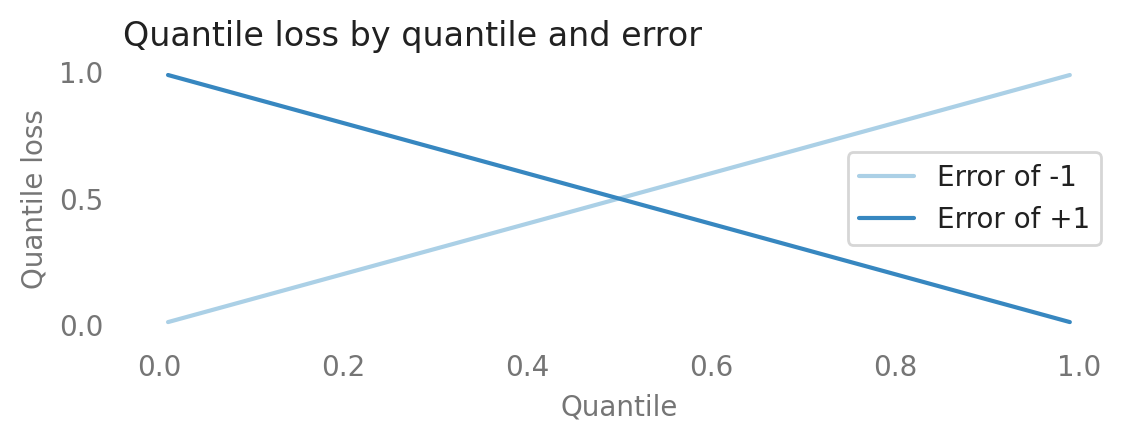

In [22]:
with sns.color_palette('Blues', 2):
    plt.plot(quantile_loss_example_q, quantile_loss_example_loss_neg1)
    plt.plot(quantile_loss_example_q, quantile_loss_example_loss_pos1)
    plt.legend(['Error of -1', 'Error of +1'])
    sns.despine(left=True, bottom=True)
    plt.xlabel('Quantile')
    plt.ylabel('Quantile loss')
    plt.title('Quantile loss by quantile and error', loc='left');

# Scatter plot for age

In [23]:
mean.AGE

69.01064356435643

In [24]:
std.AGE

27.940664897596555

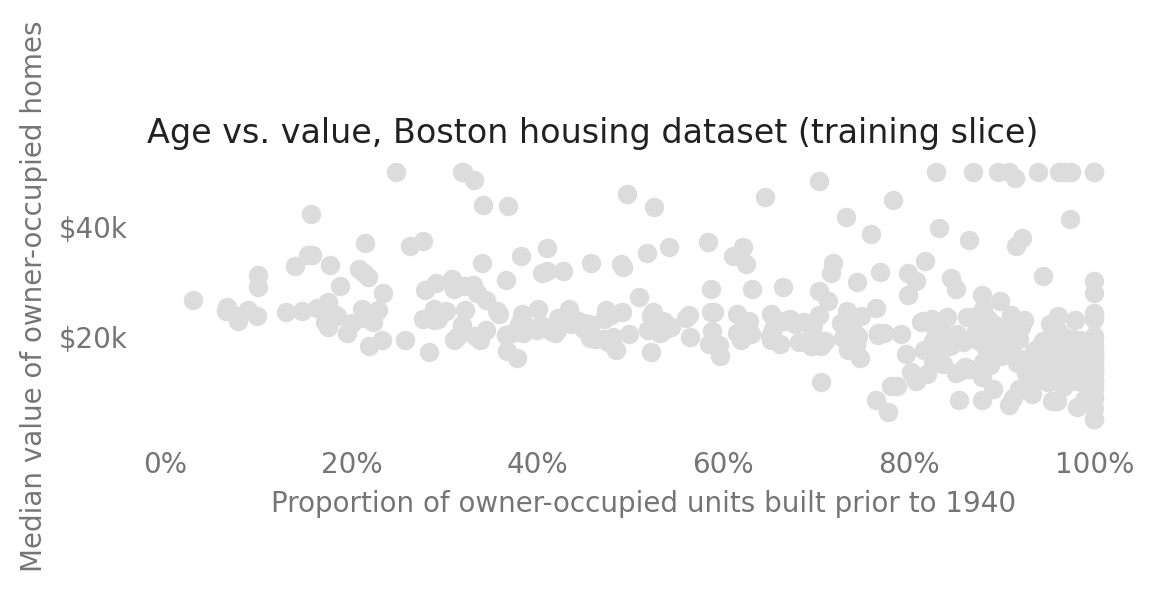

In [25]:
from matplotlib.ticker import FuncFormatter

ax = plt.scatter(x_train_denorm, train_labels, color=dot_color)
plt.title('Age vs. value, Boston housing dataset (training slice)', loc='left')
sns.despine(left=True, bottom=True)
ax.axes.xaxis.set_major_formatter(FuncFormatter(
    lambda x, _: '{:.0%}'.format(x / 100)))
ax.axes.yaxis.set_major_formatter(FuncFormatter(
    lambda y, _: '${:.0f}k'.format(y)))
plt.xlabel('Proportion of owner-occupied units built prior to 1940')
plt.ylabel('Median value of owner-occupied homes')
plt.show()

# OLS


- OLS = Ordinary Least Square
-  https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels



In [26]:
ols = sm.OLS(train_labels, X_train).fit()

In [27]:
def ols_quantile(m, X, q):
    # m: OLS model.
    # X: X matrix.
    # q: Quantile.
    #
    # Set alpha based on q. Vectorized for different values of q.
    mean_pred = m.predict(X)
    se = np.sqrt(m.scale)
    return mean_pred + norm.ppf(q) * se

In [28]:
preds.loc[preds.method == 'OLS', 'pred'] = np.concatenate(
    [ols_quantile(ols, X_test, q) for q in QUANTILES]) 

# QuantReg


- https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html



In [29]:
# Don't fit yet, since we'll fit once per quantile.
quantreg = sm.QuantReg(train_labels, X_train)  

In [30]:
preds.loc[preds.method == 'QuantReg', 'pred'] = np.concatenate(
    [quantreg.fit(q=q).predict(X_test) for q in QUANTILES]) 

# Random forests


- For more info just look at one of my other notebook



In [31]:
N_ESTIMATORS = 1000
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                    min_samples_leaf=1, random_state=3, 
                                    verbose = True, 
                                    n_jobs=-1)
rf.fit(X_train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.6s finished


RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=3,
                      verbose=True)

In [32]:
def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    # One row per record.
    rf_preds = np.array(rf_preds).transpose()  
    return np.percentile(rf_preds, q * 100, axis=1)

In [33]:
preds.loc[preds.method == 'Random forests', 'pred'] = np.concatenate(
    [rf_quantile(rf, X_test, q) for q in QUANTILES]) 

# Gradient boosted trees

In [34]:
def gb_quantile(X_train, train_labels, X, q):
    gbf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=q,
                                             n_estimators=N_ESTIMATORS,
                                             max_depth=3,
                                             learning_rate=0.1, min_samples_leaf=9,
                                             min_samples_split=9)
    gbf.fit(X_train, train_labels)
    return gbf.predict(X)

In [35]:
preds.loc[preds.method == 'Gradient boosting', 'pred'] = np.concatenate(
    [gb_quantile(X_train, train_labels, X_test, q) for q in QUANTILES]) 

# Keras


- Most people actually require quantiles as opposed to true uncertainty in an estimate. eg. 
- For a given age the weight of an individual will vary. What would be interesting is the (for arguments sake) the 10th and 90th percentile. 
- The uncertainty of the estimate of an individuals weight is less interesting.
- From https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb



In [36]:
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)

In [37]:
from tensorflow.keras import optimizers
optimizer = optimizers.Adam(0.001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [38]:
def keras_pred(x_train, train_labels, x_test, q):
    print(q)
    # Set input_dim for the number of features.
    if len(x_train.shape) == 1:
        input_dim = 1
    else:
        input_dim = x_train.shape[1]
    model = keras.Sequential([
      keras.layers.Dense(UNITS, activation=tf.nn.relu,
                         input_dim=input_dim),
      keras.layers.Dense(UNITS, activation=tf.nn.relu),
      keras.layers.Dense(1)
    ])
    
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer=optimizer)
    model.fit(x_train, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE,
              verbose=0, validation_split=0.2, callbacks=[early_stop])
    
    # Predict the quantile
    return model.predict(x_test)

In [39]:
preds.loc[preds.method == 'Keras', 'pred'] = np.concatenate(
    [keras_pred(x_train_expanded, train_labels, x_test_expanded, q) 
     for q in QUANTILES]) 

0.1
0.3
0.5
0.7
0.9


# TensorFlow


-  Adapted from https://github.com/strongio/quantile-regression-tensorflow/blob/master/Quantile%20Loss.ipynb



In [ ]:
# Initialize session
tf.disable_v2_behavior()
sess = tf.Session()

In [41]:
# Create network
class q_model:
    def __init__(self, 
                 sess, 
                 quantiles,
                 in_shape=1, 
                 out_shape=1, 
                 batch_size=32):
        
        self.sess = sess
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size
        
        self.outputs = []
        self.losses = []
        self.loss_history = []
        
        self.build_model()
        
    def build_model(self, scope='q_model', reuse=tf.AUTO_REUSE): 
        with tf.variable_scope(scope, reuse=reuse) as scope:
            self.x = tf.placeholder(tf.float32, shape=(None, self.in_shape))
            self.y = tf.placeholder(tf.float32, shape=(None, self.out_shape))

            self.layer0 = tf.layers.dense(self.x, 
                                          units=UNITS, 
                                          activation=tf.nn.relu)
            self.layer1 = tf.layers.dense(self.layer0, 
                                          units=UNITS,
                                          activation=tf.nn.relu)

            # Create outputs and losses for all quantiles
            for i, q in enumerate(self.quantiles):
                # Get output layers 
                output = tf.layers.dense(self.layer1, self.out_shape,
                                         name="{}_q{}".format(i, int(q * 100)))
                self.outputs.append(output)
                
                # Create losses
                error = tf.subtract(self.y, output)
                loss = tf.reduce_mean(tf.maximum(q * error, (q - 1) * error),
                                      axis=-1)

                self.losses.append(loss)

            # Create combined loss
            self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
            self.train_step = tf.train.AdamOptimizer().minimize(
                self.combined_loss)

    def fit(self, x, y, epochs=EPOCHS):
        for epoch in range(epochs):
            epoch_losses = []
            for idx in range(0, x.shape[0], self.batch_size):
                batch_x = x[idx : min(idx + self.batch_size, x.shape[0]), :]
                batch_y = y[idx : min(idx + self.batch_size, y.shape[0]), :]

                feed_dict = {self.x: batch_x,
                             self.y: batch_y}

                _, c_loss = self.sess.run([self.train_step, self.combined_loss],
                                          feed_dict)
                epoch_losses.append(c_loss)
                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if epoch % 100 == 0:
                print("Epoch {}: {}".format(epoch, epoch_loss))
            
    def predict(self, x):   
        # Run model to get outputs
        feed_dict = {self.x: x}
        predictions = sess.run(self.outputs, feed_dict)
        
        return predictions

In [ ]:
# Instantiate model
tf_model = q_model(sess, QUANTILES, in_shape=1, out_shape=1,
                   batch_size=BATCH_SIZE)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [43]:
# Run training
tf_model.fit(x_train_expanded, train_labels_expanded, EPOCHS)

Epoch 0: 54.19856262207031
Epoch 100: 10.769611358642578


In [44]:
preds.loc[preds.method == 'TensorFlow', 'pred'] = \
    np.array([item for sublist in tf_model.predict(x_test_expanded)
              for item in sublist])

In [45]:
# denormalise x

In [46]:
preds['x_denorm'] = denorm_AGE(preds.x)

# Visualise quantiles


- Pay particularly attention to the smothness of the predictions.



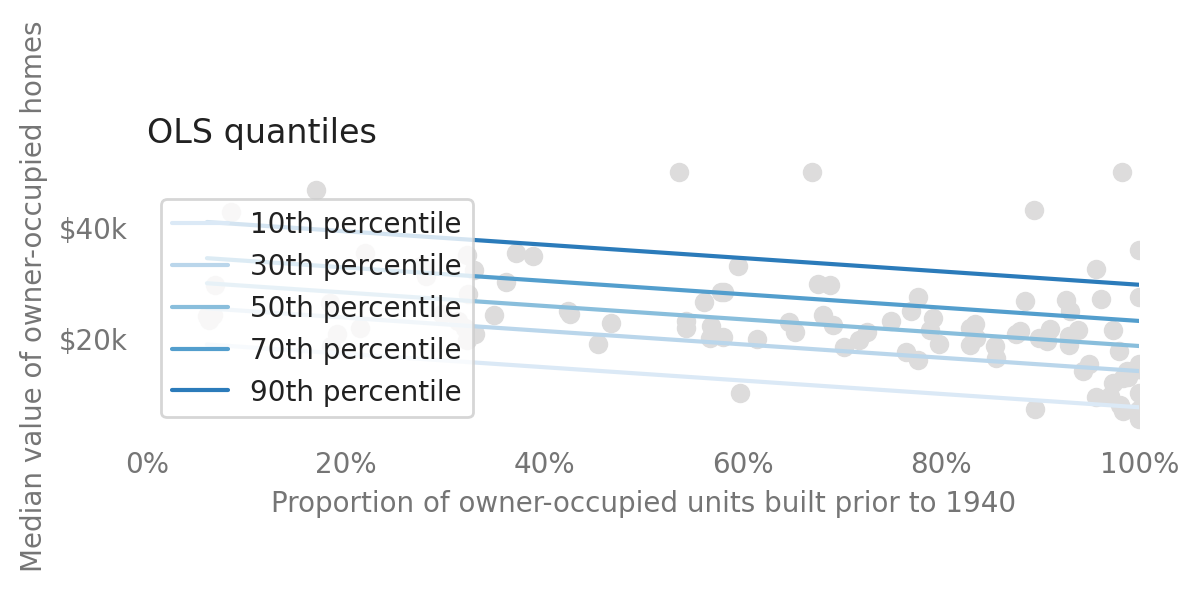

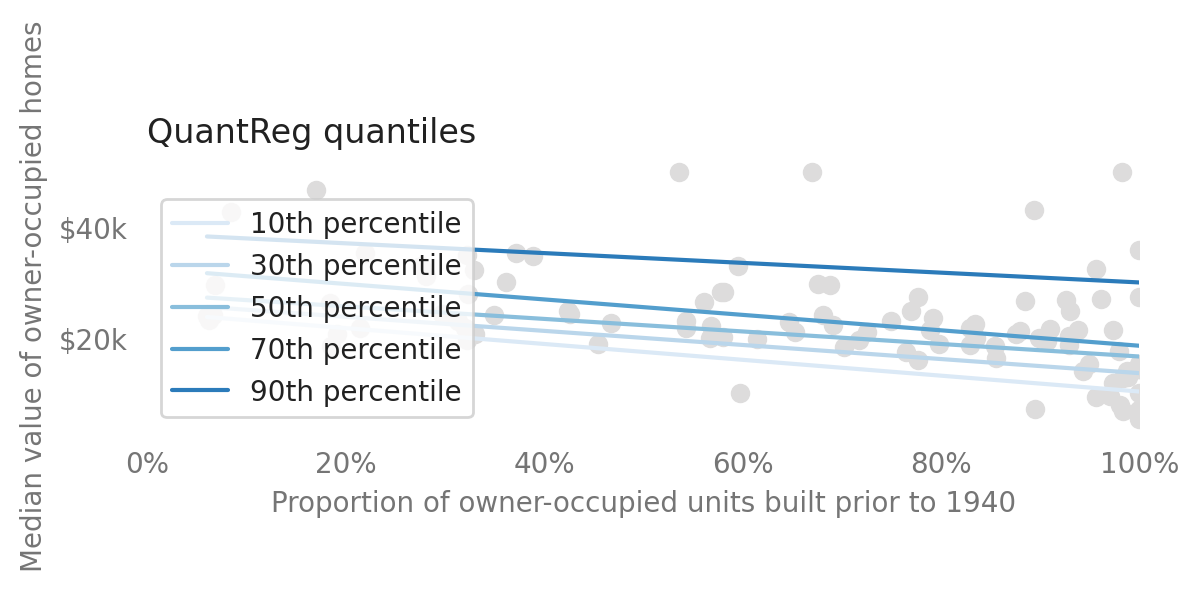

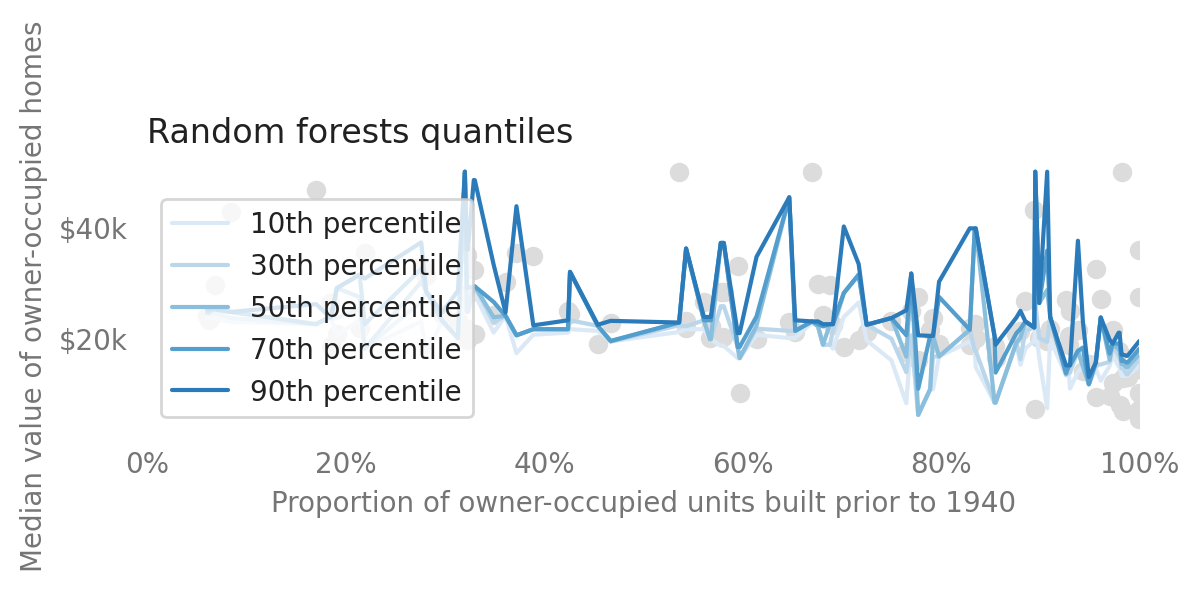

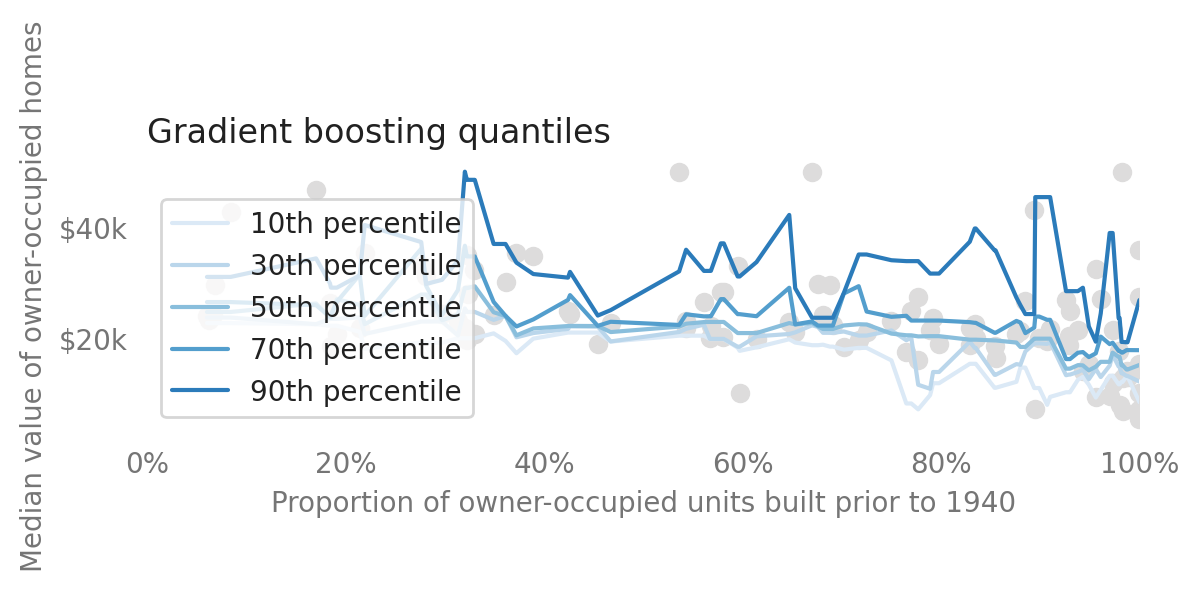

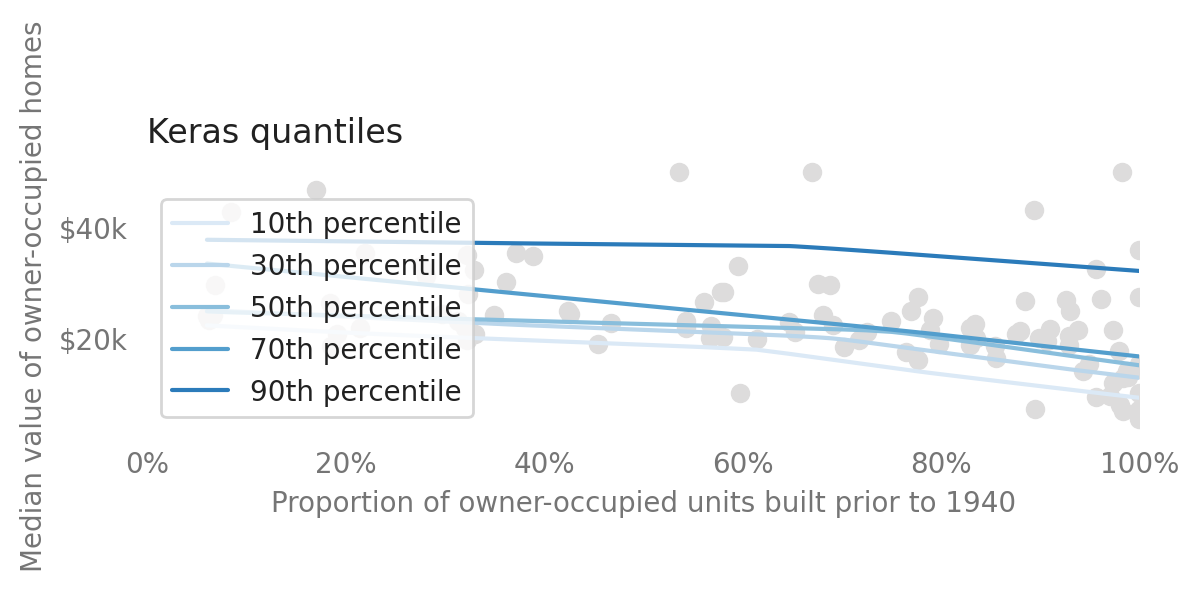

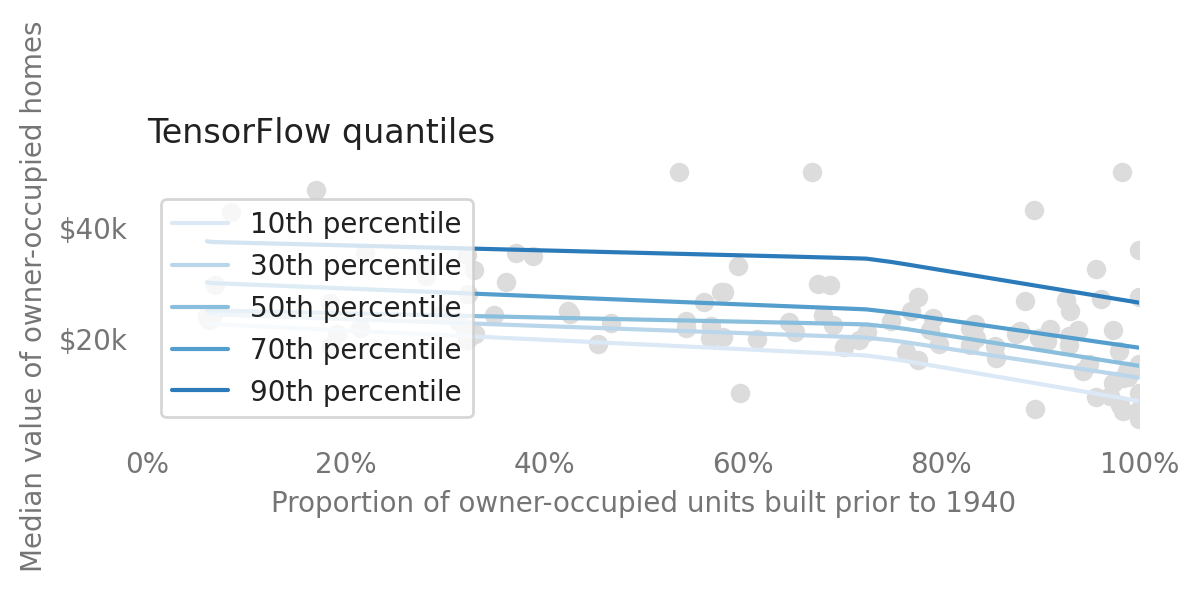

In [47]:
for i, method in enumerate(METHODS):
    ax = plt.scatter(x_test_denorm, test_labels, color=dot_color)
    plt.plot(preds[preds.method == method].pivot_table(
        index='x_denorm', columns='q', values='pred'))
    plt.legend(quantiles_legend)
    # Reversing legend isn't working, possibly because of multiple plots.
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[::-1], labels[::-1])
    plt.xlim((0, 100))
    ax.axes.xaxis.set_major_formatter(FuncFormatter(
        lambda x, _: '{:.0%}'.format(x / 100)))
    ax.axes.yaxis.set_major_formatter(FuncFormatter(
        lambda y, _: '${:.0f}k'.format(y)))
    plt.xlabel('Proportion of owner-occupied units built prior to 1940')
    plt.ylabel('Median value of owner-occupied homes')
    plt.title(method + ' quantiles', loc='left')
    sns.despine(left=True, bottom=True)
    plt.show()

# Compare quantile loss

In [48]:
preds['quantile_loss'] = quantile_loss(preds.q, preds.label, preds.pred)

In [55]:
def plot_loss_comparison(preds):
    overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
      pivot_table(index='method', values='quantile_loss').\
      sort_values('quantile_loss')
    # Show overall table.
    print(overall_loss_comparison)
  
    # Plot overall.
    with sns.color_palette("tab10", 1):
        ax = overall_loss_comparison.plot.barh()
        plt.title('Total quantile loss', loc='left')
        sns.despine(left=True, bottom=True)
        plt.xlabel('Quantile loss')
        plt.ylabel('')
        ax.legend_.remove()
  
    # Per quantile.
    per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
        pivot_table(index='q', columns='method', values='quantile_loss')
    # Sort by overall quantile loss.
    per_quantile_loss_comparison = \
        per_quantile_loss_comparison[overall_loss_comparison.index]
    print(per_quantile_loss_comparison)
  
    # Plot per quantile.
    with sns.color_palette("tab10"):
        ax = per_quantile_loss_comparison.plot.barh()
        plt.title('Quantile loss per quantile', loc='left')
        sns.despine(left=True, bottom=True)
        handles, labels = ax.get_legend_handles_labels()
        plt.xlabel('Quantile loss')
        plt.ylabel('Quantile')
        # Reverse legend.
        ax.legend(reversed(handles), reversed(labels))

                   quantile_loss
method                          
TensorFlow              2.179507
Keras                   2.245403
QuantReg                2.274849
OLS                     2.281734
Gradient boosting       2.422577
Random forests          3.191606
method  TensorFlow     Keras  QuantReg       OLS  Gradient boosting  \
q                                                                     
0.1       1.029863  1.073173  1.150024  1.218665           1.120840   
0.3       2.227937  2.263326  2.411370  2.402398           2.352626   
0.5       2.861524  2.904404  2.990252  2.970241           2.925456   
0.7       2.895121  3.074364  2.981039  2.963606           3.203561   
0.9       1.883091  1.911746  1.841559  1.853761           2.510402   

method  Random forests  
q                       
0.1           1.717716  
0.3           2.865775  
0.5           4.095943  
0.7           3.939574  
0.9           3.339022  


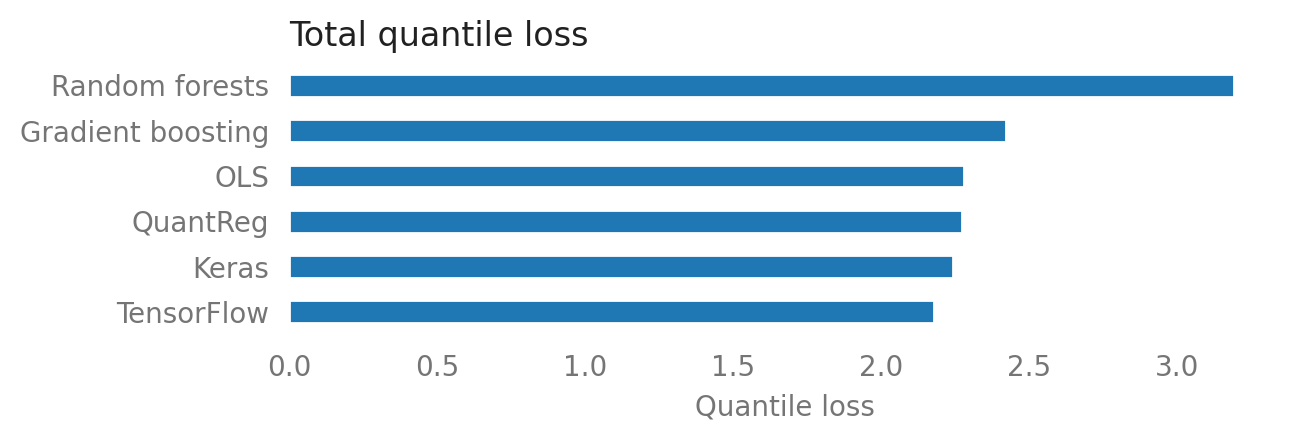

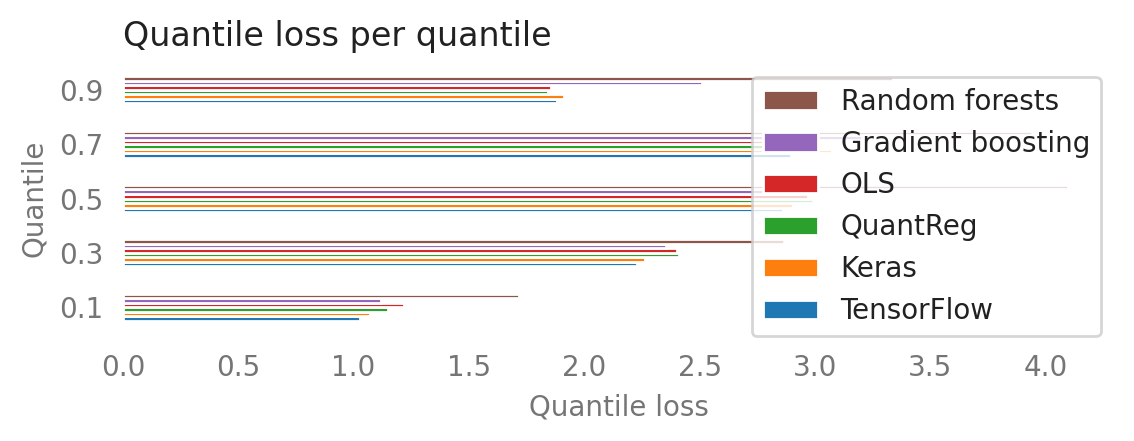

In [56]:
plot_loss_comparison(preds)

# Conclusion


- You have many options to compute the PIs.
- You can compare them all as long as the dataset is small.

